In [1]:
import numpy as np
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
import ipywidgets as widgets
from IPython.html.widgets import *
import pickle
import h5py 
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU
from keras.optimizers import Adam
import keras.backend.tensorflow_backend as KTF



%matplotlib inline

/Users/songjiechen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/songjiechen/anaconda3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
Using TensorFlow backend.


In [2]:
# constants
#DATA_PATH = ''
#TRAIN_VIDEO = os.path.join(DATA_PATH, 'drive.mp4') #'drive.mp4' 'train.mp4'
CLEAN_DATA_PATH = ''
CLEAN_IMGS_TRAIN = os.path.join(CLEAN_DATA_PATH, 'train_imgs') #train2_imgs train_imgs
ASSETS_PATH = ''

train_frames = 8616 #20400 #8616
test_frames = 10798

seeds = [1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144]


# hyperparameters
batch_size = 16
num_epochs = 15 #90 
steps_per_epoch = 400

# run specific constants
model_name = 'nvidia' #nvidia2
run_name = 'model={}-batch_size={}-num_epoch={}-steps_per_epoch={}'.format(model_name,
                                                                          batch_size,
                                                                          num_epochs,
                                                                          steps_per_epoch)

assets_filepath = os.path.join(ASSETS_PATH, 'model_assets' , run_name)
weights_loc = os.path.join(assets_filepath,'weights.h5')
history_loc=  os.path.join(assets_filepath,'history.p')
tensorboard_loc = os.path.join(assets_filepath, run_name)



In [3]:
run_name

'model=nvidia-batch_size=16-num_epoch=15-steps_per_epoch=400'

In [4]:
train_meta = pd.read_csv(os.path.join(CLEAN_DATA_PATH, 'train2_meta.csv')) #train2_meta
print('shape: ', train_meta.shape)

shape:  (20400, 3)


In [5]:
# note: there is a chance that points might appear again. as n

def train_valid_split(dframe, seed_val):
    """
    Randomly shuffle pairs of rows in the dataframe, separates train and validation data
    generates a uniform random variable 0->9, gives 20% chance to append to valid data, otherwise train_data
    return tuple (train_data, valid_data) dataframes
    """
    train_data = pd.DataFrame()
    valid_data = pd.DataFrame()
    np.random.seed(seed_val)
    for i in tqdm(range(len(dframe) - 1)):
        idx1 = np.random.randint(len(dframe) - 1)
        idx2 = idx1 + 1
        
        
        row1 = dframe.iloc[[idx1]].reset_index()
        row2 = dframe.iloc[[idx2]].reset_index()
        
        randInt = np.random.randint(9)
        if 0 <= randInt <= 1:
            valid_frames = [valid_data, row1, row2]
            valid_data = pd.concat(valid_frames, axis = 0, join = 'outer', ignore_index=False)
        if randInt >= 2:
            train_frames = [train_data, row1, row2]
            train_data = pd.concat(train_frames, axis = 0, join = 'outer', ignore_index=False)
    return train_data, valid_data

In [6]:
train_data, valid_data = train_valid_split(train_meta, seeds[0])

100%|██████████| 20399/20399 [02:22<00:00, 143.52it/s]


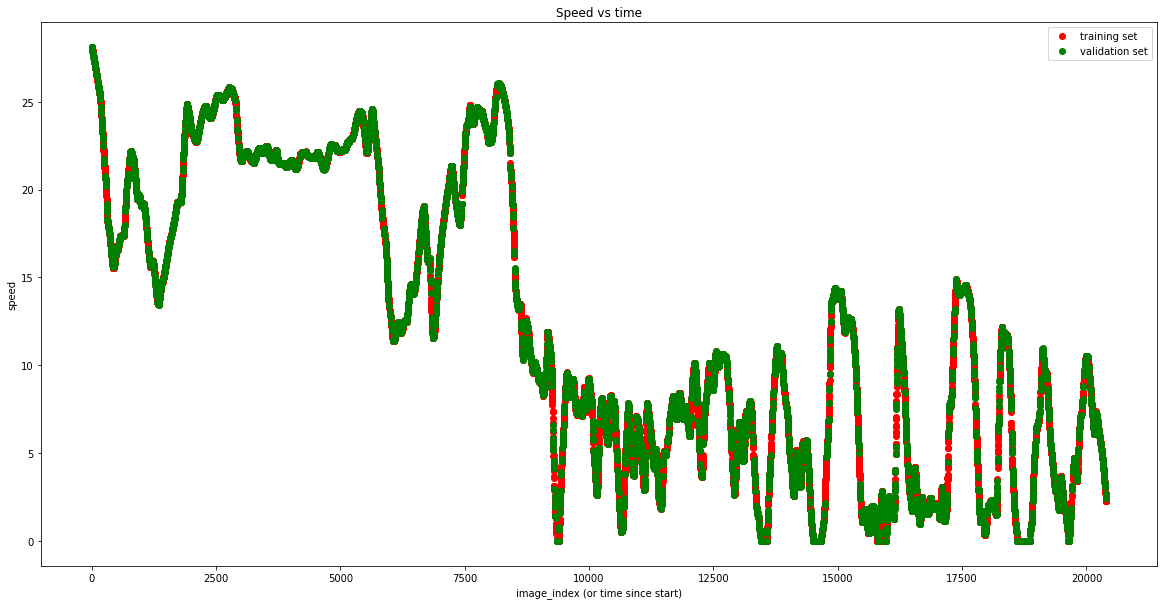

----
valid_data:  (9032, 4)
train_data:  (31766, 4)


In [7]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(train_data.sort_values(['image_index'])[['image_index']], train_data.sort_values(['image_index'])[['speed']], 'ro')
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], valid_data.sort_values(['image_index'])[['speed']], 'go')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Speed vs time')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
plt.close()

print('----')
print('valid_data: ', valid_data.shape)
print('train_data: ', train_data.shape)

In [8]:
def change_brightness(image, bright_factor):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb

In [9]:
# img=mpimg.imread(train_meta['image_path'][60])
# print('original image shape:', img.shape)
# plt.imshow(img)
# plt.show()
# plt.close()

# bright_factor = 0.7 + np.random.uniform()
# print('bright_factor:', bright_factor)
# print('brightned image')
# img=mpimg.imread(train_meta['image_path'][60])
# plt.imshow(change_brightness(img, bright_factor))
# plt.show()
# plt.close()

# Optic flow with 5 dimensions 

In [10]:
def opticalFlowDenseDim5(image_current, image_next):
    """
    input: image_current, image_next (RGB images)
    output: image_difference as data (R,G,B,A,M)
    """
    
    # TODO try gaussian blurring the image first too
    
    gray_current = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    gray_next = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)
    
    
    data = np.zeros((66, 220, 5))
    
 
    # Flow Parameters
    flow_mat = cv2.CV_32FC2
    image_scale = 0.4
    nb_images = 1
    win_size = 15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.5 # 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(gray_current, gray_next,  
                                        flow_mat, 
                                        image_scale, 
                                        nb_images, 
                                        win_size, 
                                        nb_iterations, 
                                        deg_expansion, 
                                        STD, 
                                        0)
                                        
        
    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    # get red differences
    data[:,:,0] = image_current[:,:,0] - image_next[:,:,0]
    
    # get green differences
    data[:,:,1] = image_current[:,:,1] - image_next[:,:,1]
    
    # get blue differences
    data[:,:,2] = image_current[:,:,2] - image_next[:,:,2]
    
    # get hue for data
    data[:,:,3] = ang * (180/ np.pi / 2) * (255/180)
    
    data[:,:,4] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    
    return data


In [11]:
def preprocess_image(image):
    """
    preprocesses the image
    
    input: image (480 (y), 640 (x), 3) RGB
    output: image (shape is (220, 66, 3) as RGB)
    
    This stuff is performed on my validation data and my training data
    Process: 
             1) Cropping out black spots
             3) resize to (220, 66, 3) if not done so already from perspective transform
    """
    # Crop out sky (top) (100px) and black right part (-90px)
    #image_cropped = image[100:440, :-90] # -> (380, 550, 3) #v2 for data
    image_cropped = image[25:375, :] #v1 for data
    
    image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)
    
    return image



original image shape: (480, 640, 3)


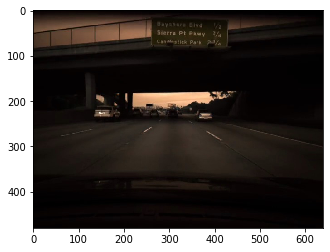

post prosessed image: (66, 220, 3)


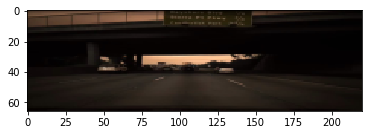

In [12]:
img=mpimg.imread(train_meta['image_path'][10])
print('original image shape:', img.shape)
plt.imshow(img)
plt.show()
plt.close()

post_img = preprocess_image(img)
print('post prosessed image:', post_img.shape)
plt.imshow(post_img)
plt.show()
plt.close()

In [13]:
def preprocess_image_valid_from_path(image_path, speed):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess_image(img)
    return img, speed

def preprocess_image_from_path(image_path, speed, bright_factor):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = change_brightness(img, bright_factor)    
    img = preprocess_image(img)
    return img, speed

In [14]:
def generate_training_data(data, batch_size = 32):
    image_batch = np.zeros((batch_size, 66, 220, 5)) # nvidia input params
    label_batch = np.zeros((batch_size))
    while True:
        for i in range(batch_size):
            # generate a random index with a uniform random distribution from 1 to len - 1
            idx = np.random.randint(1, len(data) - 1)
            
            # Generate a random bright factor to apply to both images
            bright_factor = 0.2 + np.random.uniform()
            
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            # Find the 3 respective times to determine frame order (current -> next)
            
            time_now = row_now['image_index'].values[0]
            time_prev = row_prev['image_index'].values[0]
            time_next = row_next['image_index'].values[0]
            
            if abs(time_now - time_prev) == 1 and time_now > time_prev:
                row1 = row_prev
                row2 = row_now
                
            elif abs(time_next - time_now) == 1 and time_next > time_now:
                row1 = row_now
                row2 = row_next
            else:
                print('Error generating row')            
            
            x1, y1 = preprocess_image_from_path(row1['image_path'].values[0],
                                                row1['speed'].values[0],
                                               bright_factor)
            
            # preprocess another image
            x2, y2 = preprocess_image_from_path(row2['image_path'].values[0], 
                                                row2['speed'].values[0],
                                               bright_factor)
           
            # compute optical flow send in images as RGB
            rgb_diff = opticalFlowDenseDim5(x1, x2)
                        
            # calculate mean speed
            y = np.mean([y1, y2])
            
            image_batch[i] = rgb_diff
            label_batch[i] = y
        
        #print('image_batch', image_batch.shape, ' label_batch', label_batch)
        # Shuffle the pairs before they get fed into the network
        yield shuffle(image_batch, label_batch)

In [15]:
def generate_validation_data(data):
    while True:
        for idx in range(1, len(data) - 1): # start from the second row because we may try to grab it and need its prev to be in bounds
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            # Find the 3 respective times to determine frame order (current -> next)
            
            time_now = row_now['image_index'].values[0]
            time_prev = row_prev['image_index'].values[0]
            time_next = row_next['image_index'].values[0]
            
            if abs(time_now - time_prev) == 1 and time_now > time_prev:
                row1 = row_prev
                row2 = row_now
                
            elif abs(time_next - time_now) == 1 and time_next > time_now:
                row1 = row_now
                row2 = row_next
            else:
                print('Error generating row')        
            
            x1, y1 = preprocess_image_valid_from_path(row1['image_path'].values[0], row1['speed'].values[0])
            x2, y2 = preprocess_image_valid_from_path(row2['image_path'].values[0], row2['speed'].values[0])
            
            img_diff = opticalFlowDenseDim5(x1, x2)
            img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
            y = np.mean([y1, y2])
            
            speed = np.array([[y]])
            
            #print('img_diff', img_diff.shape, ' speed', speed)
            yield img_diff, speed

In [16]:
N_img_height = 66
N_img_width = 220
N_img_channels = 5
def nvidia_model():
    inputShape = (N_img_height, N_img_width, N_img_channels)

    model = Sequential()
    # normalization    
    # perform custom normalization before lambda layer in network
    model.add(Lambda(lambda x: x/ 127.5 - 1, input_shape = inputShape))

    model.add(Convolution2D(24, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv1'))
    
    
    model.add(ELU())    
    model.add(Convolution2D(36, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv2'))
    
    model.add(ELU())    
    model.add(Convolution2D(48, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv3'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, (3, 3), 
                            strides = (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv4'))
    
    model.add(ELU())              
    model.add(Convolution2D(64, (3, 3), 
                            strides= (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv5'))
              
              
    model.add(Flatten(name = 'flatten'))
    model.add(ELU())
    model.add(Dense(100, kernel_initializer = 'he_normal', name = 'fc1'))
    model.add(ELU())
    model.add(Dense(50, kernel_initializer = 'he_normal', name = 'fc2'))
    model.add(ELU())
    model.add(Dense(10, kernel_initializer = 'he_normal', name = 'fc3'))
    model.add(ELU())
    
    # do not put activation at the end because we want to exact output, not a class identifier
    model.add(Dense(1, name = 'output', kernel_initializer = 'he_normal'))
    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = adam, loss = 'mse')

    return model

In [17]:
if not os.path.exists(assets_filepath):
    os.makedirs(assets_filepath)

In [18]:
valid_generator = generate_validation_data(valid_data)
val_size = len(valid_data.index)

earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=1, 
                              verbose=1, 
                              min_delta = 0.23,
                              mode='min',)

modelCheckpoint = ModelCheckpoint(weights_loc, 
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                 save_weights_only = True)

tensorboard = TensorBoard(log_dir=tensorboard_loc, histogram_freq=0,
                            write_graph=True, write_images=True)

callbacks_list = [modelCheckpoint, tensorboard, earlyStopping]

In [19]:
model = nvidia_model()

In [33]:
train_size = len(train_data.index)
train_generator = generate_training_data(train_data, batch_size)
history = model.fit_generator(
        train_generator, 
        steps_per_epoch = steps_per_epoch, 
        epochs = num_epochs,
        callbacks = callbacks_list,
        verbose = 1,
        validation_data = valid_generator,
        validation_steps = val_size
)

print(history)

Epoch 1/25
400/400 [==============================] - 440s 1s/step - loss: 8.4061 - val_loss: 9.2617

Epoch 00001: val_loss did not improve from 9.18588
Epoch 2/25
400/400 [==============================] - 426s 1s/step - loss: 7.3879 - val_loss: 9.6523

Epoch 00002: val_loss did not improve from 9.18588
Epoch 00002: early stopping


In [35]:
# saving history
pickle.dump(history.history, open(history_loc, "wb"))

# Post Analysis

In [36]:
# model processing hyperparameters
batch_size = 16
num_epochs = 25 #100 #90 
steps_per_epoch = 400

# run specific constants
model_name = 'nvidia' 
run_name = 'model={}-batch_size={}-num_epoch={}-steps_per_epoch={}'.format(model_name,
                                                                          batch_size,
                                                                          num_epochs,
                                                                          steps_per_epoch)

In [37]:
history = pickle.load(open(history_loc, "rb" ))
model.load_weights(weights_loc)
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer = adam, loss = 'mse')

In [38]:
val_score = model.evaluate_generator(valid_generator, steps=val_size)
print('val score:', val_score)

val score: 9.18396759020727


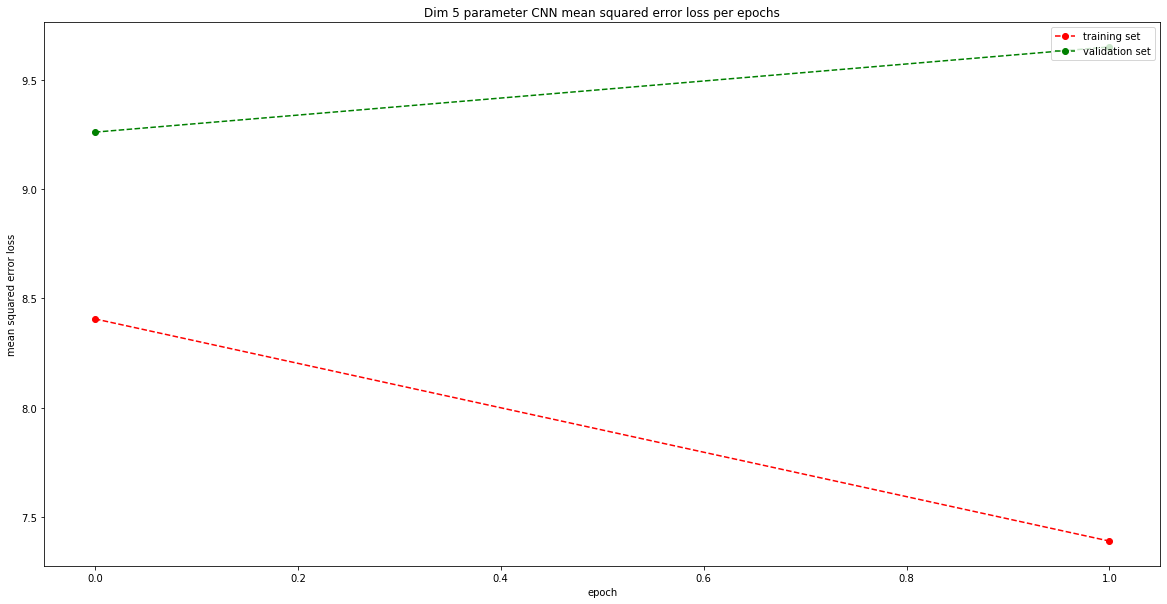

In [39]:
### plot the training and validation loss for each epoch
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(history['loss'], 'ro--')
plt.plot(history['val_loss'], 'go--')
plt.title('Dim 5 parameter CNN mean squared error loss per epochs')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
plt.close()

In [40]:
def make_predictions(data):
    for idx in tqdm(range(1, len(data.index)-1)):
        row_now = data.iloc[[idx]].reset_index()
        row_prev = data.iloc[[idx - 1]].reset_index()
        row_next = data.iloc[[idx + 1]].reset_index()
        
        time_now = row_now['image_index'].values[0]
        time_prev = row_prev['image_index'].values[0]
        time_next = row_next['image_index'].values[0]
        
        if abs(time_now - time_prev) == 1 and time_now > time_prev:
            row1 = row_prev
            row2 = row_now
        elif abs(time_next - time_now) == 1 and time_next > time_now:
            row1 = row_now
            row2 = row_next
        else:
            print('Error generating row')
        
        x1, y1 = preprocess_image_valid_from_path(row1['image_path'].values[0], row1['speed'].values[0])
        x2, y2 = preprocess_image_valid_from_path(row2['image_path'].values[0], row2['speed'].values[0])
        
        img_diff = opticalFlowDenseDim5(x1, x2)
        img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
        y = np.mean([y1, y2])

        prediction = model.predict(img_diff)
        error = abs(prediction-y2)
        
        
        #print(prediction, error, time_now)
        data.loc[data['image_index']==time_now, 'predicted_speed'] = prediction[0][0]
        data.loc[data['image_index']==time_now, 'error'] = error[0][0]

In [41]:
make_predictions(valid_data)

100%|██████████| 9030/9030 [05:37<00:00, 27.06it/s]


In [42]:
print(mean_squared_error(valid_data.iloc[1:-1, 3], 
                         valid_data.iloc[1:-1, 4]))

9.194914546301403


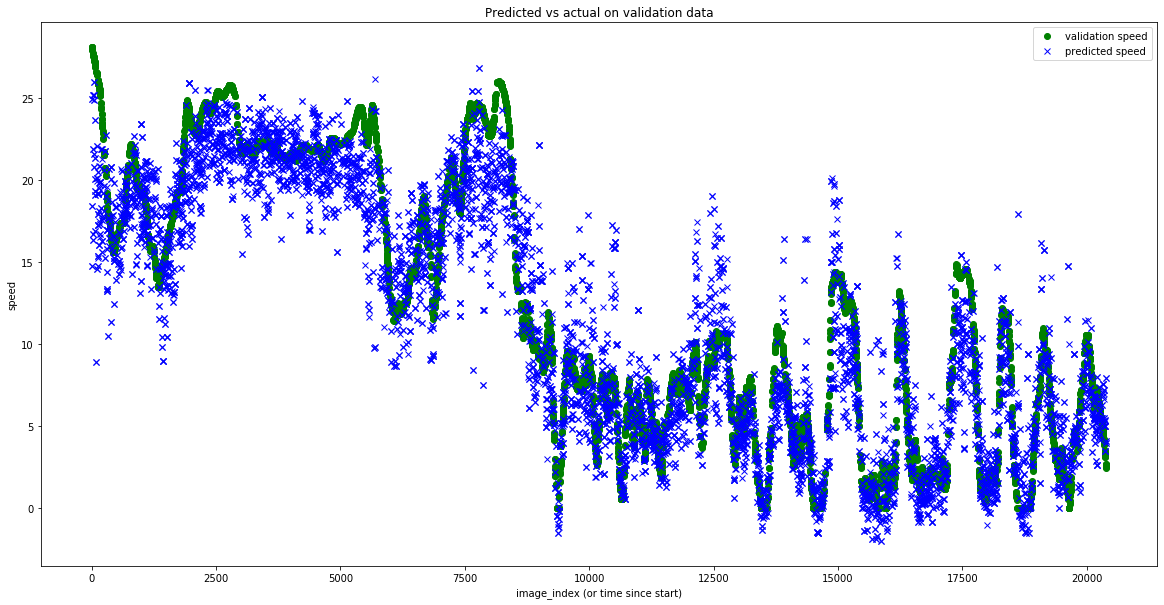

In [43]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['speed']], 'go')
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['predicted_speed']], 'bx')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Predicted vs actual on validation data')
plt.legend(['validation speed', 'predicted speed'], loc='upper right')
plt.show()
plt.close()

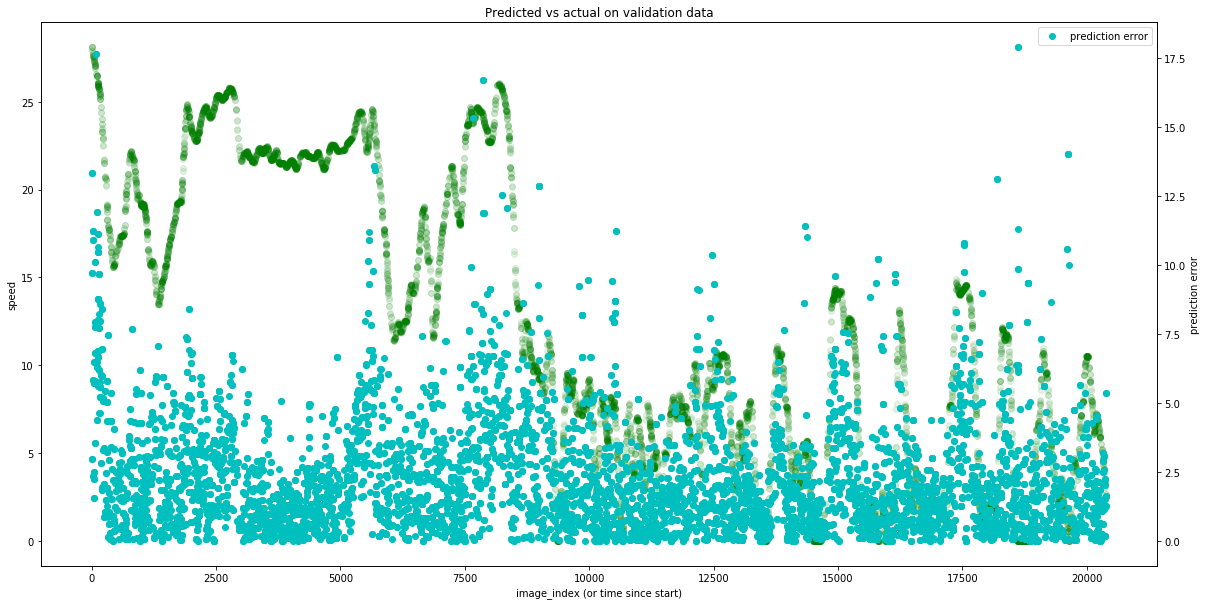

In [44]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['speed']], 'go', alpha=0.1)

ax2 = ax1.twinx()
ax2.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['error']], 'co')

ax1.set_xlabel('image_index (or time since start)')
ax1.set_ylabel('speed')
ax2.set_ylabel('prediction error')
plt.title('Predicted vs actual on validation data')
plt.legend(['prediction error'], loc='upper right')
plt.show()
plt.close()

In [45]:
def error_analysis(error_thresh):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(valid_data.sort_values(['image_index'])[['image_index']], 
             valid_data.sort_values(['image_index'])[['speed']], 'go', alpha=0.4)


    ax.plot(valid_data[valid_data['error']>error_thresh].sort_values(['image_index'])[['image_index']], 
             valid_data[valid_data['error']>error_thresh].sort_values(['image_index'])[['speed']], 'rx')


    ax.set_xlabel('image_index (or time since start)')
    ax.set_ylabel('speed')
    plt.title('Error analysis on validation data')
    plt.legend(['Ground truth', 'Incorrect prediction'], loc='upper right')
    plt.show()

interact(error_analysis, error_thresh=(0,5, 0.1))

interactive(children=(FloatSlider(value=2.0, description='error_thresh', max=5.0), Output()), _dom_classes=('w…

<function __main__.error_analysis(error_thresh)>

## Predicting on Test

In [48]:
test_meta = pd.read_csv(os.path.join(CLEAN_DATA_PATH, 'test2_meta.csv'))
#assert(test_meta.shape[0] == test_frames)
assert(test_meta.shape[1] == 3)
print('shape: ', test_meta.shape)

shape:  (8616, 3)


In [49]:
make_predictions(test_meta)

100%|██████████| 8614/8614 [06:13<00:00, 25.73it/s]


In [51]:
window_size = 25

test_meta['smooth_predicted_speed'] = test_meta['predicted_speed'].rolling(window = 25).mean()
test_meta['smooth_error'] = test_meta.apply(lambda x: x['smooth_predicted_speed'] - x['speed'], axis=1)
test_meta['smooth_predicted_speed'] = test_meta.apply(lambda x: 
                                                        x['predicted_speed'] if np.isnan(x['smooth_predicted_speed'])
                                                       else x['smooth_predicted_speed'],axis=1)
test_meta['smooth_error'] = test_meta.apply(lambda x: x['error'] if np.isnan(x['smooth_error'])
                                                       else x['smooth_error'],axis=1)


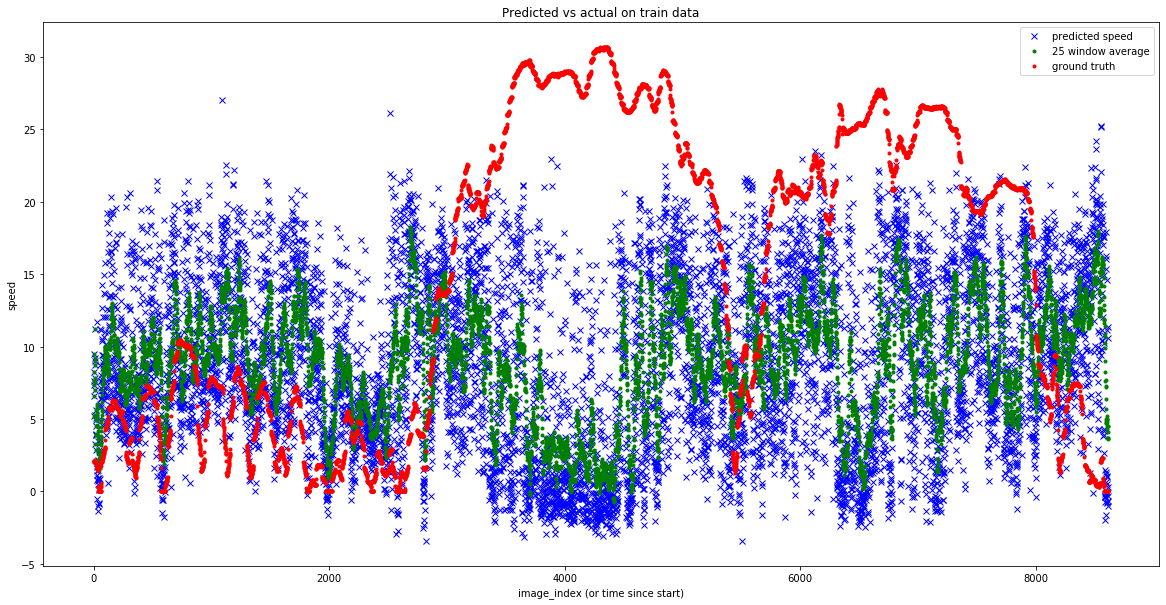

In [52]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(test_meta.sort_values(['image_index'])[['image_index']], 
         test_meta.sort_values(['image_index'])[['predicted_speed']], 'bx')
plt.plot(test_meta.sort_values(['image_index'])[['image_index']], 
         test_meta.sort_values(['image_index'])[['smooth_predicted_speed']], 'g.')
plt.plot(test_meta.sort_values(['image_index'])[['image_index']], 
         test_meta.sort_values(['image_index'])[['speed']], 'r.')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Predicted vs actual on train data')
plt.legend(['predicted speed', (str(window_size) +' window average'), 'ground truth'], loc='upper right')
plt.show()
plt.close()

In [53]:
output_file = test_meta['smooth_predicted_speed']
output_file.to_csv(os.path.join(ASSETS_PATH, 'test.txt'), index=False)

/Users/songjiechen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [54]:
output_file.head()

0         NaN
1    6.574333
2    5.204055
3    7.360848
4    7.659497
Name: smooth_predicted_speed, dtype: float64

In [56]:
print(test_meta)

             image_path  image_index     speed  predicted_speed      error  \
0        val_imgs/0.jpg            0  2.022715              NaN        NaN   
1        val_imgs/1.jpg            1  2.040872         6.574333   4.533462   
2        val_imgs/2.jpg            2  2.062394         5.204055   3.141660   
3        val_imgs/3.jpg            3  2.076283         7.360848   5.284565   
4        val_imgs/4.jpg            4  2.077074         7.659497   5.582422   
5        val_imgs/5.jpg            5  2.070870         8.253111   6.182241   
6        val_imgs/6.jpg            6  2.107572         9.476761   7.369189   
7        val_imgs/7.jpg            7  2.122324        11.216894   9.094570   
8        val_imgs/8.jpg            8  2.127576         5.260165   3.132590   
9        val_imgs/9.jpg            9  2.123339         3.278280   1.154941   
10      val_imgs/10.jpg           10  2.133369         7.038211   4.904842   
11      val_imgs/11.jpg           11  2.139515         8.975155 

In [1]:
print(mean_squared_error(test_meta.iloc[1:-1, 2], 
                         test_meta.iloc[1:-1, 3]))

NameError: name 'mean_squared_error' is not defined